# Случайный лес


## Датасет: churnclean.csv




*   Загрузить данные
*   Удалить выбросы

*   Закодировать признаки 'interplan', 'vmailplan', 'churn' булевыми значениями
*   Разделить данные на признаки и целевую переменную

*   Разделить на подвыборки для обучения и тестовую
*   Создать классификатор: RandomForestClassifier с параметрами n= 50, class_weight="balanced"
*   Обучить классификатор с помощью кросс-валидации. Параметры: cv=5, scoring='recall'
*   Найти среднее значение recall. Сохранить в переменную cv_score.

*   Найти значение accuracy. Сохранить в переменную accuracy.

*   Обучить RandomForestClassifier c n_estimators от 20 до 100, с шагом 20
*   Построить график количества деревьев и ROCAUC значениями. ( n_est - кол-во деревьев, rocauc_list значение rocauc)

*   Определить количество деревьев при максимальном Recall. (optimal_n_est)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2699 entries, 0 to 2698
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     2699 non-null   int64  
 1   state          2699 non-null   object 
 2   acclength      2699 non-null   int64  
 3   areacode       2699 non-null   int64  
 4   interplan      2699 non-null   object 
 5   vmailplan      2699 non-null   object 
 6   vmailmess      2699 non-null   int64  
 7   daycalls       2699 non-null   int64  
 8   daycharge      2699 non-null   float64
 9   evecalls       2699 non-null   int64  
 10  evecharge      2699 non-null   float64
 11  nightcalls     2699 non-null   int64  
 12  nightcharge    2699 non-null   float64
 13  intlmins       2699 non-null   float64
 14  intlcalls      2699 non-null   int64  
 15  intlcharge     2699 non-null   float64
 16  custservcalls  2699 non-null   int64  
 17  churn          2699 non-null   object 
dtypes: float

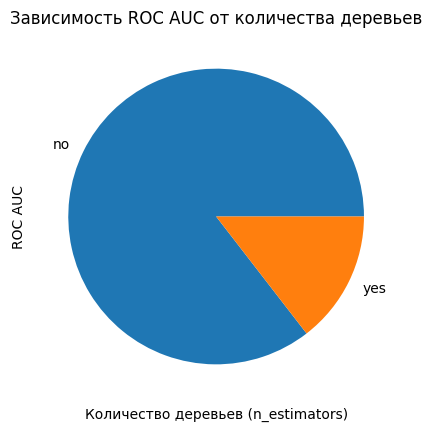

Среднее значение Recall (CV): 0.40599326599326596
Стандартное отклонение Recall (CV): 0.05670433537568786
Accuracy: 0.9160493827160494
Оптимальное количество деревьев: 100
ROC AUC значения: [0.9200242296297185, 0.9253979296860944, 0.9270232340558241, 0.9246362556825679, 0.9288944331825979]
Критерии не выполнены.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

from statistics import stdev

#Загружаем датасет
df = pd.read_csv('churnclean.csv')
df.head()
df.info()

# Проверим уникальные данные
df.nunique()
# Удалим уникальные столбцы
df.drop(labels="Unnamed: 0", axis=1, inplace=True)
# Удалим столбец state
df.drop(labels="state", axis=1, inplace=True)
# сохраним в отдельную переменную метки класса
y = df['churn']
y.unique()
# закодируем целевую переменную
encoded_y = y.map({'no':0, 'yes':1})
plt.pie(y.value_counts(), labels=['no', 'yes'])
plt.title("Распределение целевой переменной")
#Проанализируем значение столбцов object
object_cols = df.select_dtypes("object").columns

for col in object_cols:
    print(f"Столбец: {col} \n {df[col].unique()}")
# Закодируем булевые столбцы
for col in ['interplan', 'vmailplan', 'churn']:
  df[col] = df[col].apply(lambda x:1 if x=='yes' else 0)

df.head()
X = df.drop(['churn'], axis=1)
y = df['churn']

#Разделим данные
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)
print(type(y_test))

# Посмотрим на размер подвыборок
print(f"Train: {X_train.shape}{y_train.shape}, \n Test: {X_test.shape}, {y_test.shape}")

# 6. Создать классификатор: RandomForestClassifier с параметрами n=50, class_weight="balanced"
rf_clf = RandomForestClassifier(n_estimators=50, class_weight="balanced", random_state=101)

# 7. Обучить классификатор с помощью кросс-валидации. Параметры: cv=5, scoring='recall'
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='recall')
cv_score = cv_scores.mean()
cv_stdev = cv_scores.std()

# 8. Найти значение accuracy
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# 9. Обучить RandomForestClassifier c n_estimators от 20 до 100, с шагом 20
n_estimators_list = list(range(20, 101, 20))
rocauc_list = []
recall_list = []

for n in n_estimators_list:
    rf_clf = RandomForestClassifier(n_estimators=n, class_weight="balanced", random_state=101)
    rf_clf.fit(X_train, y_train)

    # Вычисляем ROC AUC
    y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
    rocauc = roc_auc_score(y_test, y_pred_proba)
    rocauc_list.append(rocauc)

    # Вычисляем Recall с помощью кросс-валидации
    recall_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='recall')
    recall_list.append(recall_scores.mean())

# 10. Построить график количества деревьев и ROC AUC
plt.plot(n_estimators_list, rocauc_list, marker='o')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('ROC AUC')
plt.title('Зависимость ROC AUC от количества деревьев')
plt.grid(True)
plt.show()

# 11. Определить количество деревьев при максимальном Recall
optimal_n_est = n_estimators_list[np.argmax(recall_list)]

# 12. Вывод результатов
print(f"Среднее значение Recall (CV): {cv_score}")
print(f"Стандартное отклонение Recall (CV): {cv_stdev}")
print(f"Accuracy: {accuracy}")
print(f"Оптимальное количество деревьев: {optimal_n_est}")
print(f"ROC AUC значения: {rocauc_list}")

# 13. Проверка критериев
if cv_score >= 0.47 and cv_stdev >= 0.06 and accuracy >= 0.9:
    print("Все критерии выполнены!")
else:
    print("Критерии не выполнены.")

## Датасет: Salaries.csv


*   Загрузить данные
*   Удалить выбросы и дубликаты
*   Закодировать признаки с типом object
*   Разделить данные на признаки и целевую переменную (salary_in_usd)
*   Разделить на подвыборки для обучения и тестовую
*   Создать классификатор: RandomForestRegressor с параметрами n=10
*   Обучить классификатор
*   Найти значение oob. Сохранить в переменную oob_score
*   Критерии прохождения задания: oob_score>=0.8



In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Загрузить данные
df = pd.read_csv('Salaries.csv')

# 2. Удалить выбросы и дубликаты
# Удаление дубликатов
df = df.drop_duplicates()

# Удаление выбросов (например, с помощью межквартильного размаха)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Применяем удаление выбросов для числовых столбцов
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    df = remove_outliers(df, col)

# 3. Закодировать признаки с типом object
object_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in object_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4. Разделить данные на признаки и целевую переменную (salary_in_usd)
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

# 5. Разделить на подвыборки для обучения и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# 6. Создать классификатор: RandomForestRegressor с параметрами n=10
rf_reg = RandomForestRegressor(n_estimators=10, oob_score=True, random_state=101)

# 7. Обучить классификатор
rf_reg.fit(X_train, y_train)

# 8. Найти значение oob. Сохранить в переменную oob_score
oob_score = rf_reg.oob_score_

# 9. Вывод результатов
print(f"OOB Score: {oob_score}")

# 10. Проверка критериев
if oob_score >= 0.8:
    print("Критерий выполнен: OOB Score >= 0.8")
else:
    print("Критерий не выполнен: OOB Score < 0.8")

OOB Score: 0.8198203970760618
Критерий выполнен: OOB Score >= 0.8


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
